# # Ticket Analysis
# This script combines traditional machine learning models and transformer-based models to classify IT tickets.
# The process includes data loading, preprocessing, model training, and evaluation.

In [1]:
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import gc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AdamW, 
    get_linear_schedule_with_warmup
)
import re

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ## Device Configuration
# Check if CUDA is available and set the device accordingly. Configure XGBoost for GPU if available.

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    xgb_gpu_params = {
        'tree_method': 'hist',
        'device': 'cuda',
        'predictor': 'gpu_predictor'
    }
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")
    xgb_gpu_params = {}

Using device: NVIDIA GeForce RTX 3090


# ## Data Loading and Preprocessing
# Load the CSV file and preprocess the data by cleaning text fields, filling missing values, and encoding labels.

In [11]:
print("Loading CSV...")
df = pd.read_csv('dataframe.csv')

# Examine data structure
print("\nDataframe Info:")
print(df.info())

print("\nSample of raw data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique values in IT Group:")
print(df['fields.customfield_15404.value'].value_counts())

# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join(text.split())
    return text.lower()

# Clean text fields
print("Cleaning text fields...")
df['fields.summary'] = df['fields.summary'].apply(clean_text)
df['fields.description'] = df['fields.description'].apply(clean_text)

print("Cleaning Data...")
df = df[[
    'fields.customfield_14201',
    'fields.assignee.displayName',
    'fields.customfield_15404.value',
    'fields.summary',
    'fields.description'
]]

print("Renaming Columns...")
df = df.rename(columns={
    'fields.customfield_14201': 'Category 1',
    'fields.assignee.displayName': 'Assignee',
    'fields.customfield_15404.value': 'IT Group',
    'fields.summary': 'Summary',
    'fields.description': 'Description'
})

print("Filling NaN values...")
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df[['IT Group', 'Assignee', 'Category 1']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1']])

print("Combining Summary and Description...")
df['combined'] = df[['Summary', 'Description']].fillna('').agg(' '.join, axis=1)

print("Encoding Labels...")
le_it_group = LabelEncoder()
df['IT Group'] = le_it_group.fit_transform(df['IT Group'])

# Ensure consecutive class labels
unique_classes = np.sort(df['IT Group'].unique())
class_mapping = {old: new for new, old in enumerate(unique_classes)}
df['IT Group'] = df['IT Group'].map(class_mapping)

print("Unique classes after remapping:", sorted(df['IT Group'].unique()))

Loading CSV...

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137558 entries, 0 to 137557
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   expand                                      137558 non-null  object 
 1   id                                          137558 non-null  int64  
 2   self                                        137558 non-null  object 
 3   key                                         137558 non-null  object 
 4   fields.summary                              137558 non-null  object 
 5   fields.customfield_14201                    137139 non-null  object 
 6   fields.description                          109329 non-null  object 
 7   fields.project.self                         137558 non-null  object 
 8   fields.project.id                           137558 non-null  int64  
 9   fields.project.key                    

# ## Balancing the Dataset
# Create a balanced dataset by sampling an equal number of instances from each class.

In [12]:
print("\nCreating balanced dataset for baseline model...")
group_counts = df['IT Group'].value_counts()
min_acceptable_samples = 500
print(f"\nOriginal class distribution:")
print(group_counts)

valid_groups = group_counts[group_counts >= min_acceptable_samples].index
df_filtered = df[df['IT Group'].isin(valid_groups)]
print(f"\nRemoved {len(group_counts) - len(valid_groups)} classes with fewer than {min_acceptable_samples} samples")

balanced_dfs = []
samples_per_class = min_acceptable_samples
for group in valid_groups:
    group_df = df_filtered[df_filtered['IT Group'] == group]
    if len(group_df) < samples_per_class * 1.5:
        n_samples = int(len(group_df) * 0.8)
    else:
        n_samples = samples_per_class
    sampled_df = group_df.sample(n=n_samples, random_state=42)
    balanced_dfs.append(sampled_df)

df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("\nFinal balanced dataset statistics:")
print(f"Total samples: {len(df_balanced)}")
print("\nSamples per class:")
print(df_balanced['IT Group'].value_counts())

df = df_balanced
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Creating balanced dataset for baseline model...

Original class distribution:
IT Group
25    41506
38    24310
13    13464
30    11037
33     7216
12     7043
20     6548
3      4964
1      4699
31     2698
27     2157
2      2026
15     1501
34     1345
36     1123
28     1119
23      924
17      888
7       595
24      503
18      428
37      368
11      345
26      180
8       167
9       117
5        81
4        59
14       57
22       47
10       23
0         8
6         3
16        3
32        2
35        1
19        1
29        1
21        1
Name: count, dtype: int64

Removed 19 classes with fewer than 500 samples

Final balanced dataset statistics:
Total samples: 9878

Samples per class:
IT Group
25    500
38    500
13    500
30    500
33    500
12    500
20    500
3     500
1     500
31    500
27    500
2     500
15    500
34    500
36    500
28    500
23    500
17    500
7     476
24    402
Name: count, dtype: int64


# ## Traditional Machine Learning Models
# Train and evaluate traditional ML models like RandomForest, XGBoost, Logistic Regression, Naive Bayes, and Linear SVC.

In [13]:
print("Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df['IT Group'], test_size=0.2, random_state=42)

print("Remapping labels to consecutive integers...")
unique_labels = sorted(set(y_train) | set(y_test))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = pd.Series(y_train).map(label_map).values
y_test = pd.Series(y_test).map(label_map).values

print("Unique labels after remapping:")
print("Train:", sorted(np.unique(y_train)))
print("Test:", sorted(np.unique(y_test)))

pipelines = {
    'RandomForest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', XGBClassifier(
            n_jobs=-1, 
            random_state=42,
            objective='multi:softmax',
            num_class=len(np.unique(y_train)),  # Make sure this matches the number of classes
            **xgb_gpu_params
        ))
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', LogisticRegression(multi_class='multinomial', max_iter=1000, n_jobs=-1))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', MultinomialNB())
    ]),
    'Linear SVC': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', LinearSVC(random_state=42, max_iter=10000))
    ])
}

results = {}
for name, pipeline in pipelines.items():
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Making predictions with {name}...")
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

Splitting Data...
Remapping labels to consecutive integers...
Unique labels after remapping:
Train: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
Test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]

Training RandomForest model...
Making predictions with RandomForest...

Training XGBoost model...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:42:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Making predictions with XGBoost...

Training Logistic Regression model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after 

Making predictions with Logistic Regression...

Training Naive Bayes model...
Making predictions with Naive Bayes...

Training Linear SVC model...
Making predictions with Linear SVC...


# ## Transformer-Based Models
# Train and evaluate transformer models like BERT and RoBERTa for text classification.

In [14]:
def transformer_classification(df, model_name, max_len=256, batch_size=4, epochs=3, accumulation_steps=4):
    le = LabelEncoder()
    labels = le.fit_transform(df['IT Group'])
    num_classes = len(np.unique(labels))
    
    texts = df['combined'].tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_classes
    ).to(device)
    
    if hasattr(model, 'gradient_checkpointing_enable'):
        model.gradient_checkpointing_enable()
    
    train_encodings = tokenizer(
        X_train, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    test_encodings = tokenizer(
        X_test, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(y_train)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(test_encodings['input_ids']),
        torch.tensor(test_encodings['attention_mask']),
        torch.tensor(y_test)
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    
    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    
    model.train()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_loader, desc=f"Training", leave=True)
        total_loss = 0
        batch_losses = []
        optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
                labels=labels
            )
            loss = outputs.loss / accumulation_steps
            total_loss += loss.item() * accumulation_steps
            batch_losses.append(loss.item() * accumulation_steps)
            
            loss.backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                progress_bar.set_postfix({
                    'loss': f"{sum(batch_losses[-accumulation_steps:]) / accumulation_steps:.4f}",
                    'avg_loss': f"{total_loss/(batch_idx+1):.4f}"
                })
                
                del outputs
                torch.cuda.empty_cache()
        
        epoch_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} completed - Average Loss: {epoch_loss:.4f}")
    
    print("\nEvaluating model...")
    model.eval()
    predictions, true_labels = [], []
    eval_progress = tqdm(test_loader, desc="Evaluating")
    
    with torch.no_grad():
        for batch in eval_progress:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            eval_progress.set_postfix({
                'batch_size': input_ids.size(0)
            })
    
    print(f"\n--- {model_name} Performance ---")
    print(classification_report(true_labels, predictions))
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'label_encoder': le,
        'predictions': predictions,
        'true_labels': true_labels
    }

print("\nTraining Transformer Models...")
transformer_models = [
    'bert-base-uncased',
    'roberta-base'
]

transformer_results = {}
for model_name in transformer_models:
    print(f"\n--- Training {model_name} ---")
    try:
        transformer_results[model_name] = transformer_classification(
            df, 
            model_name, 
            max_len=256, 
            batch_size=4, 
            epochs=3,
            accumulation_steps=4
        )
    except Exception as e:
        print(f"Error training {model_name}: {e}")


Training Transformer Models...

--- Training bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3


Training: 100%|██████████| 1976/1976 [02:09<00:00, 15.30it/s, loss=0.5461, avg_loss=1.4302]


Epoch 1/3 completed - Average Loss: 1.4302

Epoch 2/3


Training: 100%|██████████| 1976/1976 [02:10<00:00, 15.18it/s, loss=0.5707, avg_loss=0.7322]


Epoch 2/3 completed - Average Loss: 0.7322

Epoch 3/3


Training: 100%|██████████| 1976/1976 [02:09<00:00, 15.23it/s, loss=0.2341, avg_loss=0.5106]


Epoch 3/3 completed - Average Loss: 0.5106

Evaluating model...


Evaluating: 100%|██████████| 494/494 [00:08<00:00, 60.87it/s, batch_size=4]



--- bert-base-uncased Performance ---
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       102
           1       0.68      0.71      0.70        87
           2       0.80      0.87      0.84       103
           3       0.91      0.88      0.89        91
           4       0.99      0.83      0.90       105
           5       0.60      0.40      0.48       111
           6       0.91      0.86      0.88       100
           7       0.78      0.75      0.76       111
           8       0.54      0.61      0.57        94
           9       0.50      0.78      0.61       101
          10       0.91      0.89      0.90        80
          11       0.58      0.50      0.54       103
          12       0.75      0.73      0.74        91
          13       0.49      0.94      0.64       109
          14       0.67      0.36      0.47        91
          15       1.00      1.00      1.00       103
          16       0.85      0.90      0.8

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3


Training: 100%|██████████| 1976/1976 [02:12<00:00, 14.96it/s, loss=0.8074, avg_loss=1.3722]


Epoch 1/3 completed - Average Loss: 1.3722

Epoch 2/3


Training: 100%|██████████| 1976/1976 [02:11<00:00, 15.00it/s, loss=0.6990, avg_loss=0.7945]


Epoch 2/3 completed - Average Loss: 0.7945

Epoch 3/3


Training: 100%|██████████| 1976/1976 [02:11<00:00, 14.98it/s, loss=0.3769, avg_loss=0.6358]


Epoch 3/3 completed - Average Loss: 0.6358

Evaluating model...


Evaluating: 100%|██████████| 494/494 [00:07<00:00, 62.09it/s, batch_size=4]



--- roberta-base Performance ---
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       102
           1       0.82      0.57      0.68        87
           2       0.83      0.87      0.85       103
           3       0.88      0.89      0.89        91
           4       0.99      0.86      0.92       105
           5       0.59      0.15      0.24       111
           6       0.88      0.98      0.92       100
           7       0.75      0.85      0.80       111
           8       0.51      0.41      0.46        94
           9       0.64      0.60      0.62       101
          10       0.72      0.89      0.79        80
          11       0.58      0.50      0.54       103
          12       0.78      0.88      0.82        91
          13       1.00      0.01      0.02       109
          14       0.43      0.70      0.53        91
          15       1.00      1.00      1.00       103
          16       0.86      0.85      0.85    

# ## Save Models
# Save the trained transformer models to disk.

In [15]:
for name, result in transformer_results.items():
    model_path = f'{name}_model.pth'
    torch.save(result['model'].state_dict(), model_path)
    print(f"Saved {name} model to {model_path}")

Saved bert-base-uncased model to bert-base-uncased_model.pth
Saved roberta-base model to roberta-base_model.pth


# ## Clear Memory
# Clear memory to free up resources.

In [16]:
print("Clearing Memory...")
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("Done!") 
# %%

Clearing Memory...
Done!



Model Performance Comparison:
                 Model      Model Type  Accuracy
5    bert-base-uncased     Transformer  0.751518
6         roberta-base     Transformer  0.731781
4           Linear SVC  Traditional ML  0.706984
2  Logistic Regression  Traditional ML  0.705466
3          Naive Bayes  Traditional ML  0.690789
0         RandomForest  Traditional ML  0.665992
1              XGBoost  Traditional ML  0.083502


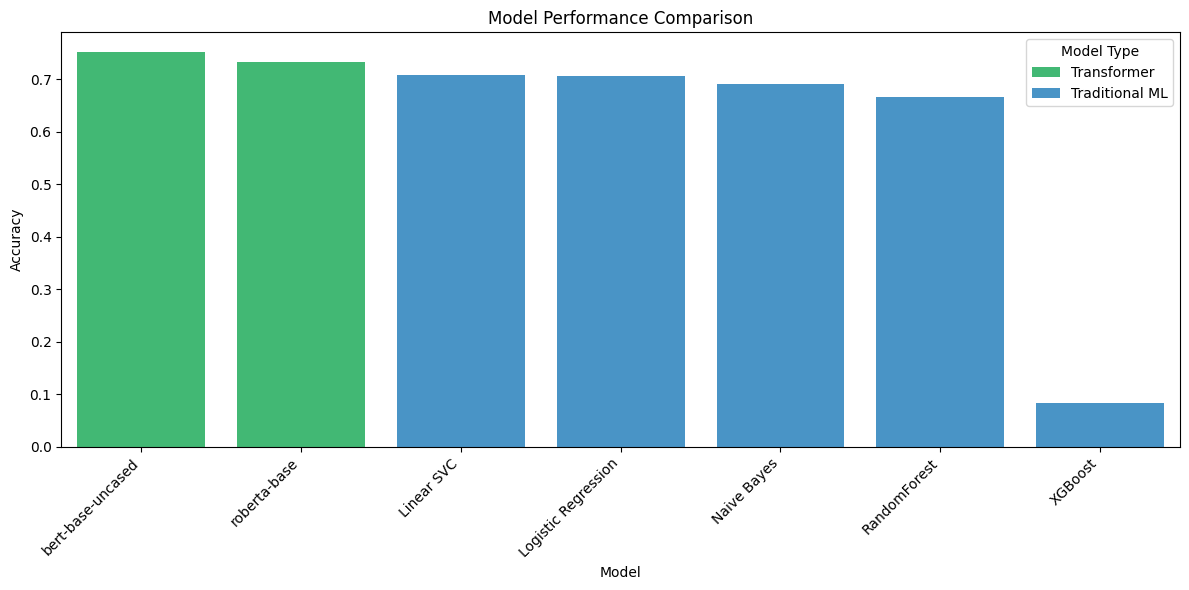


Detailed Classification Reports:

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       102
           1       0.64      0.60      0.62        87
           2       0.80      0.79      0.79       103
           3       0.79      0.92      0.85        91
           4       0.93      0.83      0.87       105
           5       0.35      0.11      0.17       111
           6       0.84      0.97      0.90       100
           7       0.70      0.72      0.71       111
           8       0.43      0.46      0.44        94
           9       0.47      0.46      0.46       101
          10       0.80      0.80      0.80        80
          11       0.38      0.49      0.42       103
          12       0.55      0.70      0.62        91
          13       0.36      0.39      0.37       109
          14       0.41      0.35      0.38        91
          15       1.00      1.00      1.00       103
          

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine results from both traditional ML and transformer models
all_results = {}

# Add traditional ML results
for name, result in results.items():
    all_results[name] = {
        'accuracy': result['accuracy'],
        'classification_report': result['classification_report'],
        'model_type': 'Traditional ML'
    }

# Add transformer results
for name in transformer_results:
    # Extract accuracy from the last evaluation metrics
    true_labels = transformer_results[name]['true_labels']
    predictions = transformer_results[name]['predictions']
    
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    
    all_results[name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'model_type': 'Transformer'
    }

# Create a DataFrame for visualization
performance_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[name]['accuracy'] for name in all_results],
    'Model Type': [all_results[name]['model_type'] for name in all_results]
})

# Sort by accuracy
performance_df = performance_df.sort_values('Accuracy', ascending=False)

# Display the DataFrame
print("\nModel Performance Comparison:")
print(performance_df[['Model', 'Model Type', 'Accuracy']])

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=performance_df,
    x='Model',
    y='Accuracy',
    hue='Model Type',
    palette=['#2ecc71', '#3498db']
)

plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display detailed classification reports
print("\nDetailed Classification Reports:")
for name in all_results:
    print(f"\n{name} Classification Report:")
    print(all_results[name]['classification_report']) 
# %%